In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial

import wolff

# Track calculation errors
np.seterr('raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [2]:
def similarity(data, theta, angspace, bin_width):
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    timesteps = data.shape[2]
    
    cos_amp = np.zeros((num_trials, timesteps))
    distances = np.zeros((num_trials, len(angspace), timesteps))
    
    calc_sim_part = partial(calc_sim, data, theta, angspace, bin_width)
    
    if __name__ == '__main__':
        with multiprocessing.Pool(20) as pool:
            calcs = pool.imap(calc_sim_part, [trl for trl in range(num_trials)], chunksize=10)
            for trl in range(num_trials):
                (cos_amp[trl,], distances[trl,]) = next(calcs)
                clear_output(wait=True)
                print(trl+1)

    return (cos_amp, distances)

def calc_sim(data, theta, angspace, bin_width, trl):
#     print(trl)
    
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    timesteps = data.shape[2]

    # distances.shape: bins by time
    distances = np.empty((len(angspace), timesteps))
    # cos_amp.shape: time
    cos_amp = np.empty(timesteps)
    
    # Get all data except trl
    trn_dat = data[np.arange(num_trials) != trl, :, :]
    # Get all angles except the one associated with trl
    trn_angle = theta[np.arange(num_trials) != trl]
    # m.shape: bins by channels by time
    m = np.empty((len(angspace), num_channels, timesteps))

    # Average the training data into orientation bins relative to the
    # test-trial's orientation
    for b in range(0, len(angspace)):
        angle_dists = np.abs(np.angle(np.exp(1j*trn_angle) / np.exp(1j*(theta[trl] - angspace[b]))))
        m[b, :, :] = np.mean(trn_dat[angle_dists < bin_width, : , :], 0)

    for ti in range(0, timesteps):
        # Using np.cov gives different results than the matlab script
        sigma = covdiag(trn_dat[:, :, ti])
        sigma = np.linalg.pinv(sigma)
        # Calculate the distances between the trial and all angle bins
        # distances[trl, i, ti] = distance.mahalanobis(m[i, :, ti], data[trl, :, ti], sigma)
#             distances[trl, :, ti] = np.array([distance.mahalanobis(means, data[trl, :, ti], sigma) for means in m[:, :, ti]])
        distances[:, ti] = mahalanobis(m[:, :, ti], data[trl, :, ti], sigma)

        # Convolve cosine of angspace with distances
        # Since a perfect decoding distance curve resembles a reversed
        # cosine (higher distance means higher value), the value is reversed
        # for ease of interpretation, so that higher values mean better
        # decoding
        mean_centred = distances[:, ti].T - np.mean(distances[:, ti])
        cos_amp[ti] = -(np.mean(np.cos(angspace) * mean_centred))
        
    return (cos_amp, distances)

def covdiag(m):
    # m (t*n): t iid observations on n random variables
    # sigma (n*n): Invertible covariance matrix estimator

    # Subtract column means from every row
    (t, n) = m.shape
    m = m - np.mean(m, axis=0)

    # Compute sample covariance matrix
    sample = (1 / t) * np.matmul(m.T, m)

    # Compute prior
    prior = np.diag(np.diag(sample))

    # Compute shrinkage parameters
    d = 1/n * np.linalg.norm(sample - prior, 'fro') ** 2
    y = m ** 2
    r2 = 1 / n / t ** 2 * np.sum(np.matmul(y.T, y)) - 1 / n / t * np.sum(sample ** 2)

    # Compute the estimator
    shrinkage = max(0., min(1., r2 / d))
    return shrinkage * prior + (1 - shrinkage) * sample

def mahalanobis(u, v, VI):
    # u.shape: bins by channels
    # v.shape: channels
    # VI.shape: channels by channels

    # delta.shape: bins by channels
    delta = u - v
    # dot(delta, VI).shape: bins by channels
    # delta.T.shape: channels by bins
    # dot(dot(delta, VI), delta.T).shape: bins by bins
    return np.sqrt(np.diag(np.dot(np.dot(delta, VI), delta.T)))

In [3]:
path = '/Users/share/Chiel4Loran/exp2/sim3/'
mem1_file = 'neuro_mem2_1.npy'
mem2_file = 'neuro_mem2_2.npy'
angles_file = 'initial_angles2.npy'

In [30]:
mem_data1 = np.load(path + mem1_file) # trials by timesteps by neurons

<IPython.core.display.Javascript object>


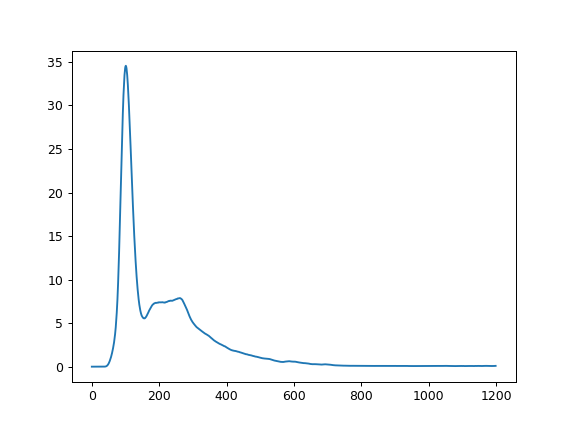

In [31]:
plt.close()

meaned1 = np.mean(np.mean(mem_data1, 0), 1)
plt.plot(meaned1)
plt.show()

In [32]:
mem_data2 = np.load(path + mem2_file)

<IPython.core.display.Javascript object>


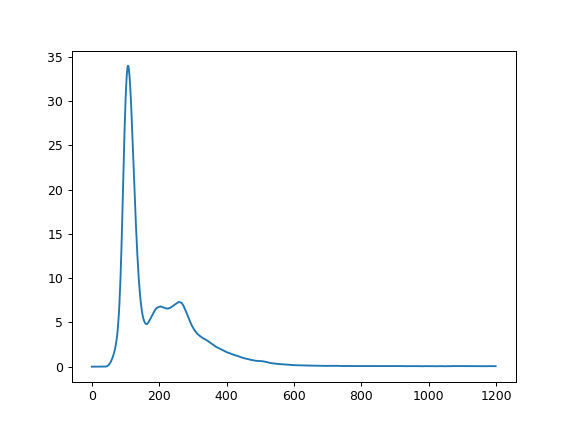

In [33]:
plt.close()

meaned2 = np.mean(np.mean(mem_data2, 0), 1)
plt.plot(meaned2)
plt.show()

In [34]:
angles = np.load(path + angles_file)
# Convert to radians
angles = angles / 360 * 2 * np.pi
# 'Scale' the angles
angles *= 2

In [9]:
def group(mem_data):
    cut_data = mem_data[:, :500, :] # trials by 500 by neurons
    num_channels = 17
    neurons = np.mean(cut_data, 1).T # neurons by trials
    kmeans = KMeans(n_clusters=num_channels, n_init=20, n_jobs=10, tol=1e-20).fit(neurons)
    
    data = np.empty((mem_data.shape[0], num_channels, mem_data.shape[1])) # trials by num_channels by timesteps
    for channel in range(num_channels):
        clear_output(wait=True)
        print(str(channel + 1) + "/" + str(num_channels))
        data[:, channel, :] = np.mean(mem_data[:, :, kmeans.labels_ == channel], axis=2)
        
    return data

In [35]:
data1 = group(mem_data1)

17/17


In [36]:
data2 = group(mem_data2)

17/17


In [37]:
# Add noise to prevent division by zero errors in covdiag()
data1 += np.random.normal(scale=0.5, size=data1.shape)
data2 += np.random.normal(scale=0.5, size=data2.shape)

In [117]:
# SKIP
data -= np.expand_dims(np.mean(data, 1), 1)

In [38]:
bin_width = np.pi / 6
angspace = np.arange(-np.pi, np.pi, bin_width) # with 'scaled' angles
# angspace = np.arange(-0.5*np.pi, 0.5*np.pi+bin_width, bin_width)

if __name__ == '__main__':
    (cos_amp1, distances1) = wolff.similarity_p(data1, angles, angspace, bin_width, num_cores=40)
    (cos_amp2, distances2) = wolff.similarity_p(data2, angles, angspace, bin_width, num_cores=40)

360


<IPython.core.display.Javascript object>


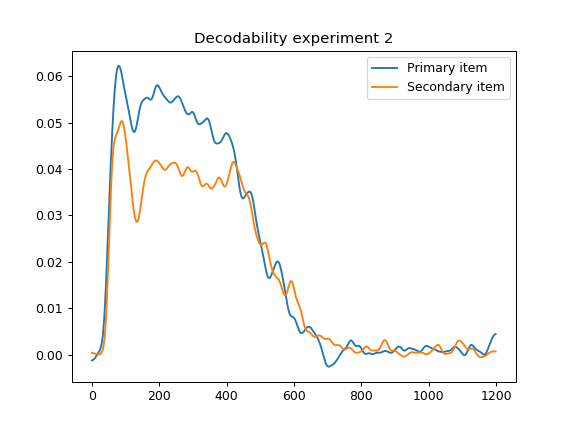

In [40]:
plt.close()

cos_amp_filtered1 = gaussian_filter(np.mean(cos_amp1, axis=0), sigma=8)
cos_amp_filtered2 = gaussian_filter(np.mean(cos_amp2, axis=0), sigma=8)
# cos_amp_filtered = np.mean(cos_amp, axis=0)

plt.title("Decodability experiment 2")

plt.plot(cos_amp_filtered1, label='Primary item')
plt.plot(cos_amp_filtered2, label='Secondary item')
# plt.plot(meaned / 35 * 0.05)

plt.legend()

plt.show()

<IPython.core.display.Javascript object>


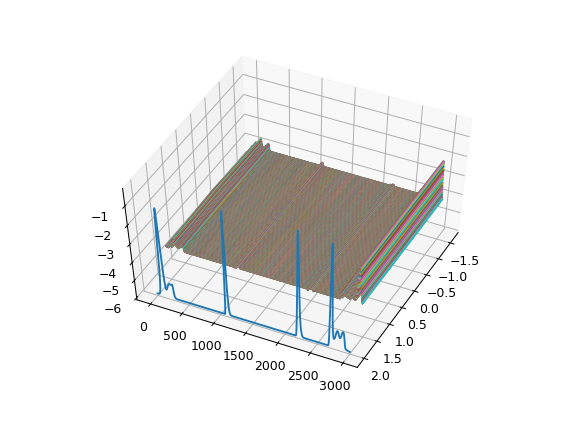

In [52]:
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(3000):
    ax.plot(angspace, angspace.shape[0]*[i], -np.mean(distances[:, :, i], 0))
    
ax.plot(distances.shape[2]*[2], range(distances.shape[2]), meaned / 35 * 6 - 6)

# for i in range(100):
#     ax.plot(angspace, angspace.shape[0]*[i], -np.mean(distances[:, :, i+800], 0))
    
# ax.plot(100*[2], range(100), (meaned / 35 * 6 - 6)[800:900])
    
# ax = fig.add_subplot(122)
# ax.plot(np.mean(cos_amp, 0))

plt.show()

<IPython.core.display.Javascript object>


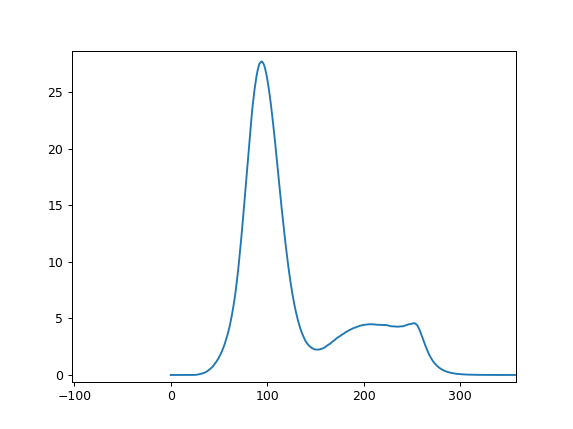

In [4]:
plt.plot(np.mean(np.mean(np.load('data/neuro_mem3.npy'), 0), 1))